In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

train = pd.read_csv ('train.csv')
test = pd.read_csv ('test.csv')

train.columns = map (str.lower, train.columns)
test.columns = map (str.lower, test.columns)
def group_ages(df, cut_points, label_names):
    df['age'] = df['age'].fillna(-0.5)
    df['age_cat'] = pd.cut (df['age'], cut_points, labels=label_names)
    return df

def create_dummies (df, column_name):
    dummies = pd.get_dummies (df[column_name], prefix=column_name)
    df = pd.concat ([df, dummies], axis=1)
    return df

cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
age_group_labels = ['missing', 'infant', 'child', 'teenager', 
    'young_adult', 'adult', 'senior']
train = group_ages (train, cut_points, age_group_labels)
test = group_ages (test, cut_points, age_group_labels)

predictive_labels = ['pclass', 'sex', 'age_cat']
for label in predictive_labels:
    train = create_dummies (train, label)
    test = create_dummies (test, label)

# Additional work from the feature prep step
train['embarked'] = train['embarked'].fillna('S')
test['embarked'] = test['embarked'].fillna('S')
train = create_dummies (train, 'embarked')
test = create_dummies (test, 'embarked')

# Make sure the new columns all conform to lower case
train.columns = map (str.lower, train.columns)
test.columns = map (str.lower, test.columns)

# convert these columns to be on the same scale
from sklearn.preprocessing import minmax_scale
columns = ["sibsp", "parch"]
for col in columns:
    train[col + '_scaled'] = minmax_scale(train[col])
    test[col + '_scaled'] = minmax_scale(test[col])

def group_fares(df, cut_points, label_names):
    df['fare'] = df['fare'].fillna(-0.5)
    df['fare_cat'] = pd.cut (df['fare'], cut_points, labels=label_names)
    return df

fare_group_labels = ['missing', '0-12', '12-50', '50-100', '100+']
cut_points = [-1, 0, 12, 50, 100, 1000]

train = group_fares (train, cut_points, fare_group_labels)
test = group_fares (test, cut_points, fare_group_labels) 
train = create_dummies (train, ['fare_cat'])
test = create_dummies (test, ['fare_cat'])

# Make sure the new columns all conform to lower case
train.columns = map (str.lower, train.columns)
test.columns = map (str.lower, test.columns)

# extract info from title
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["title"] = extracted_titles.map(titles)
extracted_titles = test["name"].str.extract(' ([A-Za-z]+)\.',expand=False)
test["title"] = extracted_titles.map(titles)

train["cabin_type"] = train["cabin"].str[0]
train["cabin_type"] = train["cabin_type"].fillna("Unknown")

test["cabin_type"] = test["cabin"].str[0]
test["cabin_type"] = test["cabin_type"].fillna("Unknown")

for column in ["title","cabin_type"]:
    train = create_dummies(train,column)
    test = create_dummies(test,column)

# Make sure the new columns all conform to lower case
train.columns = map (str.lower, train.columns)
test.columns = map (str.lower, test.columns)

exclude = ['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'age_cat', 'fare_cat', 'title', 'cabin_type', 'cabin_type_unknown']
columns = list(train.drop(columns=exclude).columns)

# Lets figure out which features are the most useful by running a regression 
# model and looking at the coefficients.abs
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit (train[columns], train['survived'])
feature_importance = pd.Series (lr.coef_[0], index=columns)
ordered_feature_importance = feature_importance.abs().sort_values()

columns = list(ordered_feature_importance.sort_values (ascending=False).index)[:27]
target = ['survived']

# remove a few columns
exclude = ['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'age_cat', 'fare_cat', 'title', 'cabin_type', 'cabin_type_unknown', 'sex_male', 'sex_female', 'pclass_2', 'age_cat_teenager', 'fare_cat_12-50','title_master', 'cabin_type_a', 'cabin_type_t']
columns = list(train.drop(columns=exclude).columns)

# Done with massaging data. Now split train into train & test
np.random.seed(1)
train = train.reindex(np.random.permutation(train.index))

In [2]:
"""
Logistic Regression
"""
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
lr = LogisticRegression()
scores = cross_val_score (lr, train[columns], train['survived'], cv=10)
accuracy = scores.mean()
print (accuracy)

0.8148689138576778


In [3]:
"""
K-Nearest Neighbors
"""
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier (n_neighbors = 5)
scores = cross_val_score (knn, train[columns], train['survived'], cv=10)
accuracy = scores.mean()
print (accuracy)

0.8159675405742822


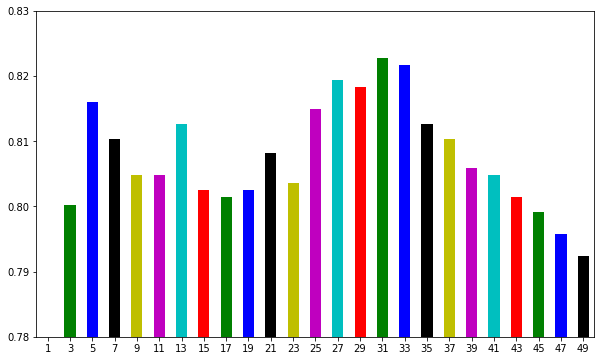

In [5]:
# try scaling up neighbors
knn_scores = dict()
for k in range (1,50,2):
    knn = KNeighborsClassifier (n_neighbors = k)
    scores = cross_val_score (knn, train[columns], train['survived'], cv=10)
    accuracy = scores.mean()
    knn_scores[k] = accuracy

pd.Series(knn_scores).plot.bar(figsize=(10,6), ylim=(0.78,0.83), color=list('rgbkymc'), rot=0)
plt.show()

In [14]:
"""
    Best model
"""
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier (n_neighbors = 31)
scores = cross_val_score (knn, train[columns], train['survived'], cv=10)
accuracy = scores.mean()
print (accuracy)

0.8227340823970037


In [16]:
# Now train on the whole training set and predict the test results
knn.fit (train[columns], train[target])
predictions = knn.predict (test[columns])

In [13]:
# Try a grid search
from sklearn.model_selection import GridSearchCV
hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}
knn = KNeighborsClassifier ()
grid = GridSearchCV(knn,param_grid=hyperparameters,cv=10)
grid.fit (train[columns], train['survived'])
best_params = grid.best_params_
best_score = grid.best_score_
print (best_score)

0.8182397003745319


In [ ]:
# Now train on the whole training set and predict the test results
rf_model.fit (train[columns_reduced], train[target])
predictions = rf_model.predict (test[columns_reduced])

In [17]:
# Create the Kaggle submission file
kg_df = pd.DataFrame()
kg_df['PassengerId'] = test['passengerid']
kg_df['Survived'] = predictions
kg_df.to_csv ('submission.csv', index=False)